# Montgomery Crime Predictor Modeling
---

## Target = 'Street name'
### Dataset Source: [dataMontgomery](https://data.montgomerycountymd.gov/Public-Safety/Crime/icn6-v9z3)
---

### Column Description of Original Dataset
ID - Police Incident Number

Offense Code - Offense_Code is the code for an offense committed within the incident as defined by the National Incident-Based Reporting System (NIBRS) of the Criminal Justice Information Services (CJIS) Division Uniform Crime Reporting (UCR) Program.

CR Number - Police Report Number

Dispatch Date/Time - The actual date and time a Officer was dispatched

NIBRS Code - FBI NIBRS codes: National Incident-Based Reporting System (NIBRS) is an incident-based reporting system used by law enforcement agencies in the United States for collecting and reporting data on crimes. Local, state and federal agencies generate NIBRS data from their records management systems.

Victims - Number of Victims

Crime Name1 - Crime against Society/Person/Property or Other

Crime Name2 - Describes the NIBRS_CODE

Crime Name3 - Describes the OFFENSE_CODE

Police District Name - Name of District (Rockville,Weaton etc.)

Block Address - Address in 100 block level

City - City Name

State - State(Maryland)

Zip Code - Zip code

Agency - Assigned Police Department

Place - Place description

Sector - Police sector name, a subset of District

Beat - Police patrol area, a subset of Sector

PRA - Police Response Area, a subset of Beat

Address Number - House or Business Number

Street Prefix - North, South, East, West

Street Name - Name of the Street

Street Suffix - Quadrant (NW, SW, etc)

Street Type - Ave, Drive, Road, etc

Start_Date_Time - Occurred from date/time

End_Date_Time - Occurred to date/time

Latitude - Latitude Coordinate

Longitude - Longitude Coordinate

Police District Number - Major Police Boundary

Location - Location Coordinate

In [1]:
# import pandas as pd 
import os

# All imports 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
import pandas_profiling as pp

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer 
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import tree
from sklearn.model_selection import cross_val_score

# scipy
import scipy.stats as st
from scipy.stats import uniform, randint

from sklearn import tree
from sklearn.model_selection import cross_val_score

# pipeline
from sklearn.pipeline import make_pipeline
import category_encoders as ce
from category_encoders.ordinal import OrdinalEncoder

# plotly
import plotly.express as px

# date-time
from datetime import datetime

# eli5
import eli5
from eli5.sklearn import PermutationImportance

# pdp
from pdpbox import pdp

In [2]:
# XGB
from xgboost.sklearn import XGBClassifier  
from xgboost.sklearn import XGBRegressor
import xgboost as xgb

In [45]:
# model loader
import joblib

In [3]:
# Set pandas's max row display
pd.set_option('display.max_row',1000)

# Set pandas's max column width to 50
pd.set_option('display.max_columns',200)

# Set Seaborn style to default
sns.set_style('darkgrid')

In [4]:
pwd

'/Users/yonipineda/lambda_folder/montgomery-crime-project/Montgomery-Project/notebooks'

In [8]:
# load cleaned df
df = pd.read_csv('Cleaned_Crime.csv', index_col=0)

In [10]:
# check df
s = df.shape
print(f"Assert the shape is correct: {s}")
df.head()

Assert the shape is correct: (38046, 27)


Victims              Crime_Type Police District Name  \
99         1                   Other   MONTGOMERY VILLAGE   
102        1   Crime Against Society           GERMANTOWN   
108        1   Crime Against Society              WHEATON   
118        1   Crime Against Society              WHEATON   
124        1  Crime Against Property              WHEATON   

            Block Address           City State  Zip Code Agency  \
99   700 BLK  RUSSELL AVE   GAITHERSBURG    MD   20877.0   MCPD   
102   Other Block Address     GERMANTOWN    MD   20874.0   MCPD   
108   Other Block Address  SILVER SPRING    MD   20902.0   MCPD   
118   Other Block Address  SILVER SPRING    MD   20902.0   MCPD   
124   Other Block Address  SILVER SPRING    MD   20902.0   MCPD   

                        Place Sector Beat    PRA  Address Number  \
99   Parking Lot - Commercial      R  6R1  548.0           700.0   
102  Parking Lot - Commercial      M  5M1  470.0         19700.0   
108               Other Place      L  4L1  366.0         23600.0   
118               Other Place      L  4L1  536.0         12300.0   
124               Other Place      L  4L1  360.0          1100.0   

    Street Prefix Street Name Street Suffix Street Type   Latitude  Longitude  \
99              W     RUSSELL             E         AVE  39.150670 -77.204063   
102             W   FREDERICK             E          RD  39.178539 -77.238524   
108             W     GEORGIA             E         AVE  39.055842 -77.049960   
118             W     GEORGIA             E         AVE  39.058066 -77.050032   
124             W  UNIVERSITY             W         BLV  39.035857 -77.026918   

    Police District Number  Second  Minute  Hour  Week  Day  Month  Year  
99                      6D       0      42    10    43   27     10  2019  
102                     5D       0      44    21    26    1      7  2016  
108                     4D       0      15     2     2    8      1  2020  
118                     4D       0      27    20    26    1      7  2016  
124                     4D       0      33    14    42   19     10  2019

# Prediction Model 
---

In the Montgomery_Cleaning notebook, There is a model with a good test score. Will use that. Maybe Ill try something new, maybe.

### Split Data

In [34]:
# Train/test splits 
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [35]:
# train val split
train, val = train_test_split(train, test_size=0.2, random_state=42)

In [36]:
# checking shape
tr = train.shape
v = val.shape
te = test.shape
print(f"Split Shape: Train {tr}, Validate {v}, Test {te}")

Split Shape: Train (24348, 27), Validate (6088, 27), Test (7610, 27)


In [37]:
# NEW TARGET: AS OF 5/30/20
train['Street Name'].value_counts(normalize=True)

GEORGIA          0.251602
FREDERICK        0.159561
VEIRS MILL       0.133481
UNIVERSITY       0.102883
NEW HAMPSHIRE    0.102760
ROCKVILLE        0.095490
COLESVILLE       0.064194
RANDOLPH         0.045301
RUSSELL          0.044726
Name: Street Name, dtype: float64

In [38]:
# columns
train.columns

Index(['Victims', 'Crime_Type', 'Police District Name', 'Block Address',
       'City', 'State', 'Zip Code', 'Agency', 'Place', 'Sector', 'Beat', 'PRA',
       'Address Number', 'Street Prefix', 'Street Name', 'Street Suffix',
       'Street Type', 'Latitude', 'Longitude', 'Police District Number',
       'Second', 'Minute', 'Hour', 'Week', 'Day', 'Month', 'Year'],
      dtype='object')

### Set Features and Target

In [39]:
# Set target and features
target = 'Street Name'

features = ['Place', 'Hour', 'Minute', 'Month', 'Victims', 'Crime_Type']

#features = train.drop(columns=target).columns.tolist()
# set train, val, test with target and feature
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

### Train the data on a RandomForest model with GridSearch for hyper-param optimization. 

In [40]:
# pipe using GridSearchCV
pipe = Pipeline([
                        ('encoder', OrdinalEncoder()),
                        ('imputer', SimpleImputer(strategy='median')),
                        ('model', RandomForestClassifier())
])

In [41]:
# using GridsearchCV to get best parameters
params = {
    "model__min_samples_leaf": [1, 2, 3]
}

search = GridSearchCV(pipe, params, n_jobs=-1)
search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_) 

Best parameter (CV score=0.264):
{'model__min_samples_leaf': 3}


In [42]:
# pipe with suggested min_sample_leaf - 3
pipe = Pipeline([
                        ('encoder', OrdinalEncoder()),
                        ('imputer', SimpleImputer(strategy='median')),
                        ('model', RandomForestClassifier(min_samples_leaf=3))
])

In [43]:
# fit pipe
X_train_cat = pd.concat([X_train, X_val])
y_train_cat = pd.concat([y_train, y_val])
%time pipe.fit(X_train_cat, y_train_cat)

CPU times: user 477 ms, sys: 19.5 ms, total: 496 ms
Wall time: 509 ms


Pipeline(memory=None,
         steps=[('encoder',
                 OrdinalEncoder(cols=['Place', 'Crime_Type'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'Place',
                                          'data_type': dtype('O'),
                                          'mapping': Other Place                     1
Residence - Apartment/Condo     2
Parking Lot - Commercial        3
Street - In vehicle             4
Residence - Single Family       5
Other/Unknown                   6
Parking Lot - Residential       7
Street - R...
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_

In [44]:
# check score
print('Validation Accuracy:', pipe.score(X_val, y_val))

Validation Accuracy: 0.562910643889619


In [47]:
# Fitting the model to the test dataset
pipe.fit(X_test, y_test)

Pipeline(memory=None,
         steps=[('encoder',
                 OrdinalEncoder(cols=['Place', 'Crime_Type'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'Place',
                                          'data_type': dtype('O'),
                                          'mapping': Other Place                     1
Residence - Apartment/Condo     2
Parking Lot - Commercial        3
Street - In vehicle             4
Residence - Single Family       5
Other/Unknown                   6
Parking Lot - Residential       7
Street - R...
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_

In [48]:
# Predict our test sample using pipe4
y_pred = pipe.predict(X_test)

In [49]:
# Test score
# Test score = ~59%
print('Test Score Using RandomForestClassifier W/ GridSearchCV:', accuracy_score(y_test, y_pred))

Test Score Using RandomForestClassifier W/ GridSearchCV: 0.5909329829172142


## Visualizations for the Model

- Will be used for the insights and process page in the app

In [51]:
from sklearn.metrics import classification_report, confusion_matrix

#The classification_report will give precision, recall, and F1
print(classification_report(y_test, y_pred))

               precision    recall  f1-score   support

   COLESVILLE       0.71      0.30      0.42       481
    FREDERICK       0.60      0.61      0.61      1183
      GEORGIA       0.53      0.87      0.66      1956
NEW HAMPSHIRE       0.69      0.47      0.56       782
     RANDOLPH       0.75      0.36      0.49       337
    ROCKVILLE       0.63      0.46      0.53       743
      RUSSELL       0.72      0.34      0.46       340
   UNIVERSITY       0.72      0.46      0.56       769
   VEIRS MILL       0.55      0.61      0.58      1019

     accuracy                           0.59      7610
    macro avg       0.66      0.50      0.54      7610
 weighted avg       0.62      0.59      0.58      7610



#### Feature Importance

In [62]:
# Feature Importance for my final selected model
# The time and place is a great predictor of the type of crimes that will occur
pipe = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy = "mean"),
    RandomForestClassifier(max_depth = 15, n_estimators = 824, 
                           min_samples_leaf = 5, random_state = 42, n_jobs = -1)
    )

pipe.fit(X_train_cat, y_train_cat)

rf = pipe.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)
plt.figure(figsize=(10,6))
plt.rcParams['axes.facecolor'] = 'blue'
plt.title("Feature Importances")
plt.xlabel("Importance of the Features")
plt.ylabel("Name of the Feature")
importances.sort_values().plot.barh(color='white');

### Permutation Feature Importance

In [63]:
# set up for Permutation Feature Importance
transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [64]:
# 1. Fit permuter
permuter = PermutationImportance(
    model, 
    scoring='accuracy', 
    n_iter=5, 
    random_state=42
)

permuter.fit(X_val_transformed, y_val)

PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       n_estimators=100,
                                                     

In [65]:
# features names
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

Victims      -0.000263
Crime_Type    0.030946
Place         0.038535
Month         0.042674
Minute        0.043233
Hour          0.049606
dtype: float64

In [66]:
# eli5 Permutation feature importance
eli5.show_weights(
    permuter, 
    top=None, 
    feature_names=feature_names 
)

## Partial Dependence Plot

In [67]:
from pdpbox.pdp import pdp_isolate, pdp_plot

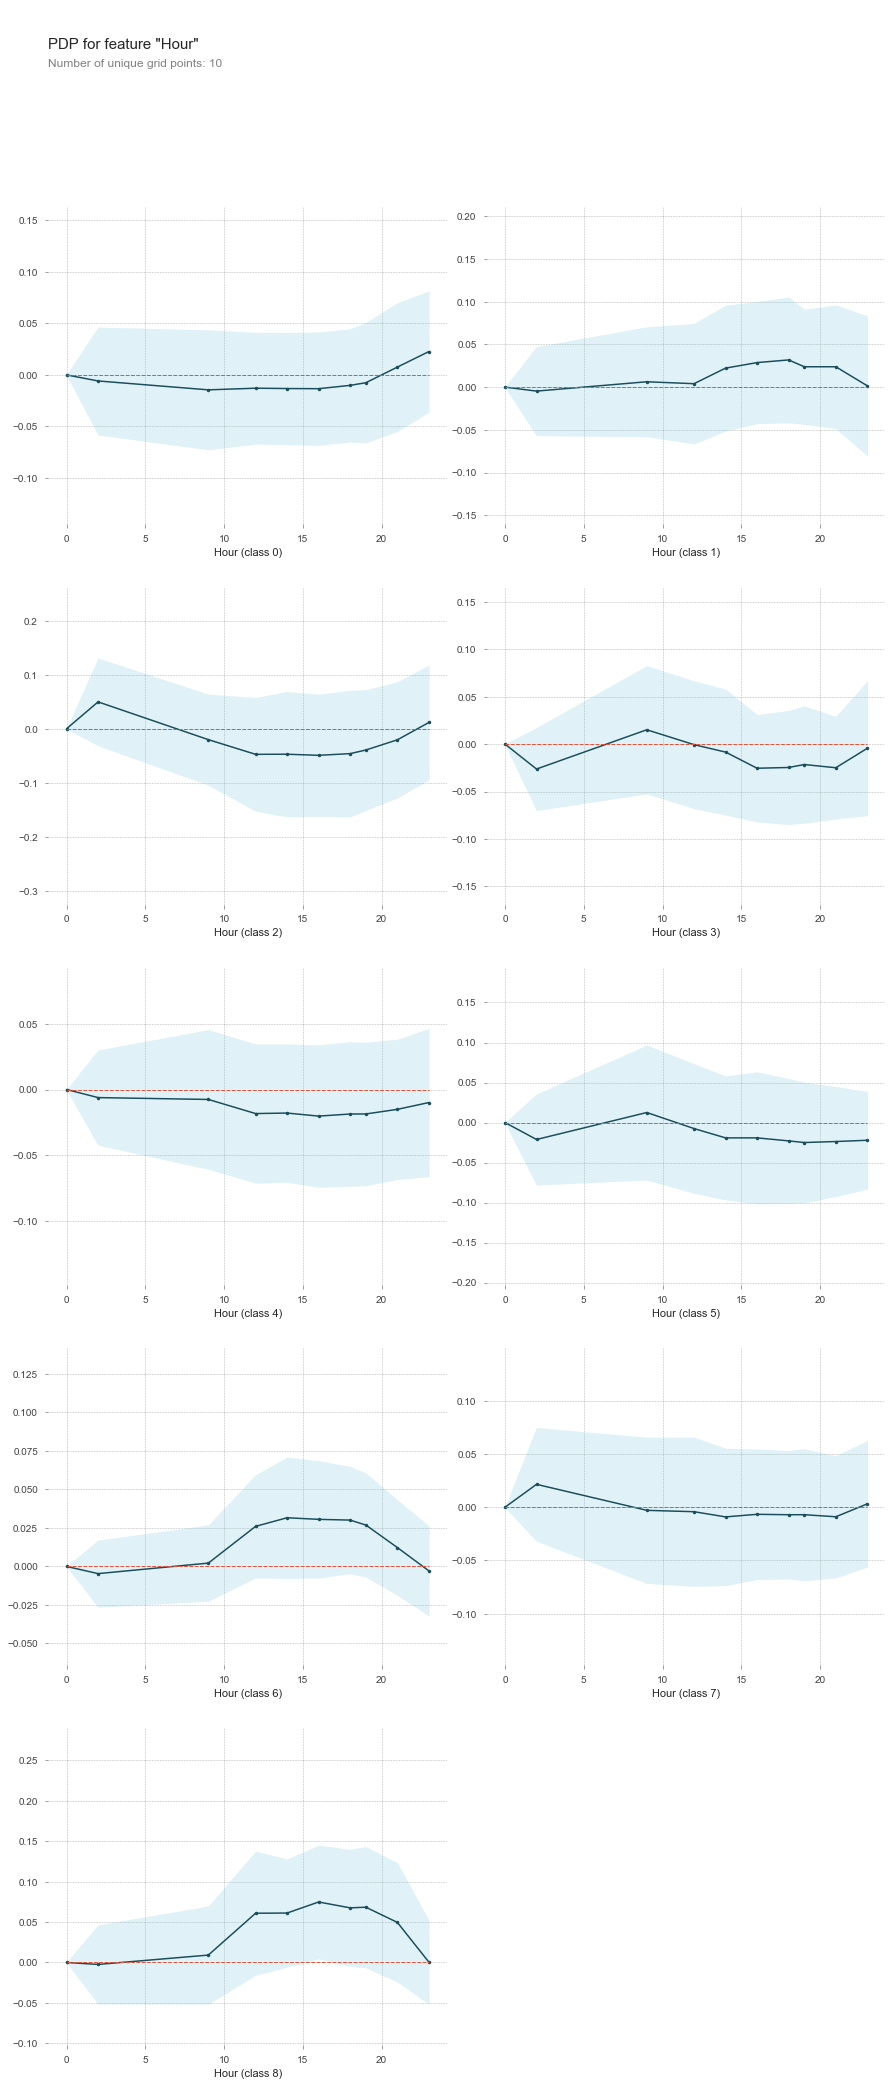

In [68]:
# pdp plot for Hour
plt.rcParams['figure.dpi'] = 72

%matplotlib inline
feature = "Hour"
isolated = pdp.pdp_isolate(model = pipe, 
                                 dataset = X_test, 
                                 model_features = X_test.columns, 
                                 feature = feature)
pdp_plot(isolated, feature_name=feature);

In [69]:
# PPP with Ice Curve for Hour
# PDP: Partial Dependence Plot
# ICE: Individual Conditional Expectation
pdp_plot(isolated, feature_name=feature, plot_lines=True, 
         frac_to_plot=0.01)

plt.xlim(20000,150000);

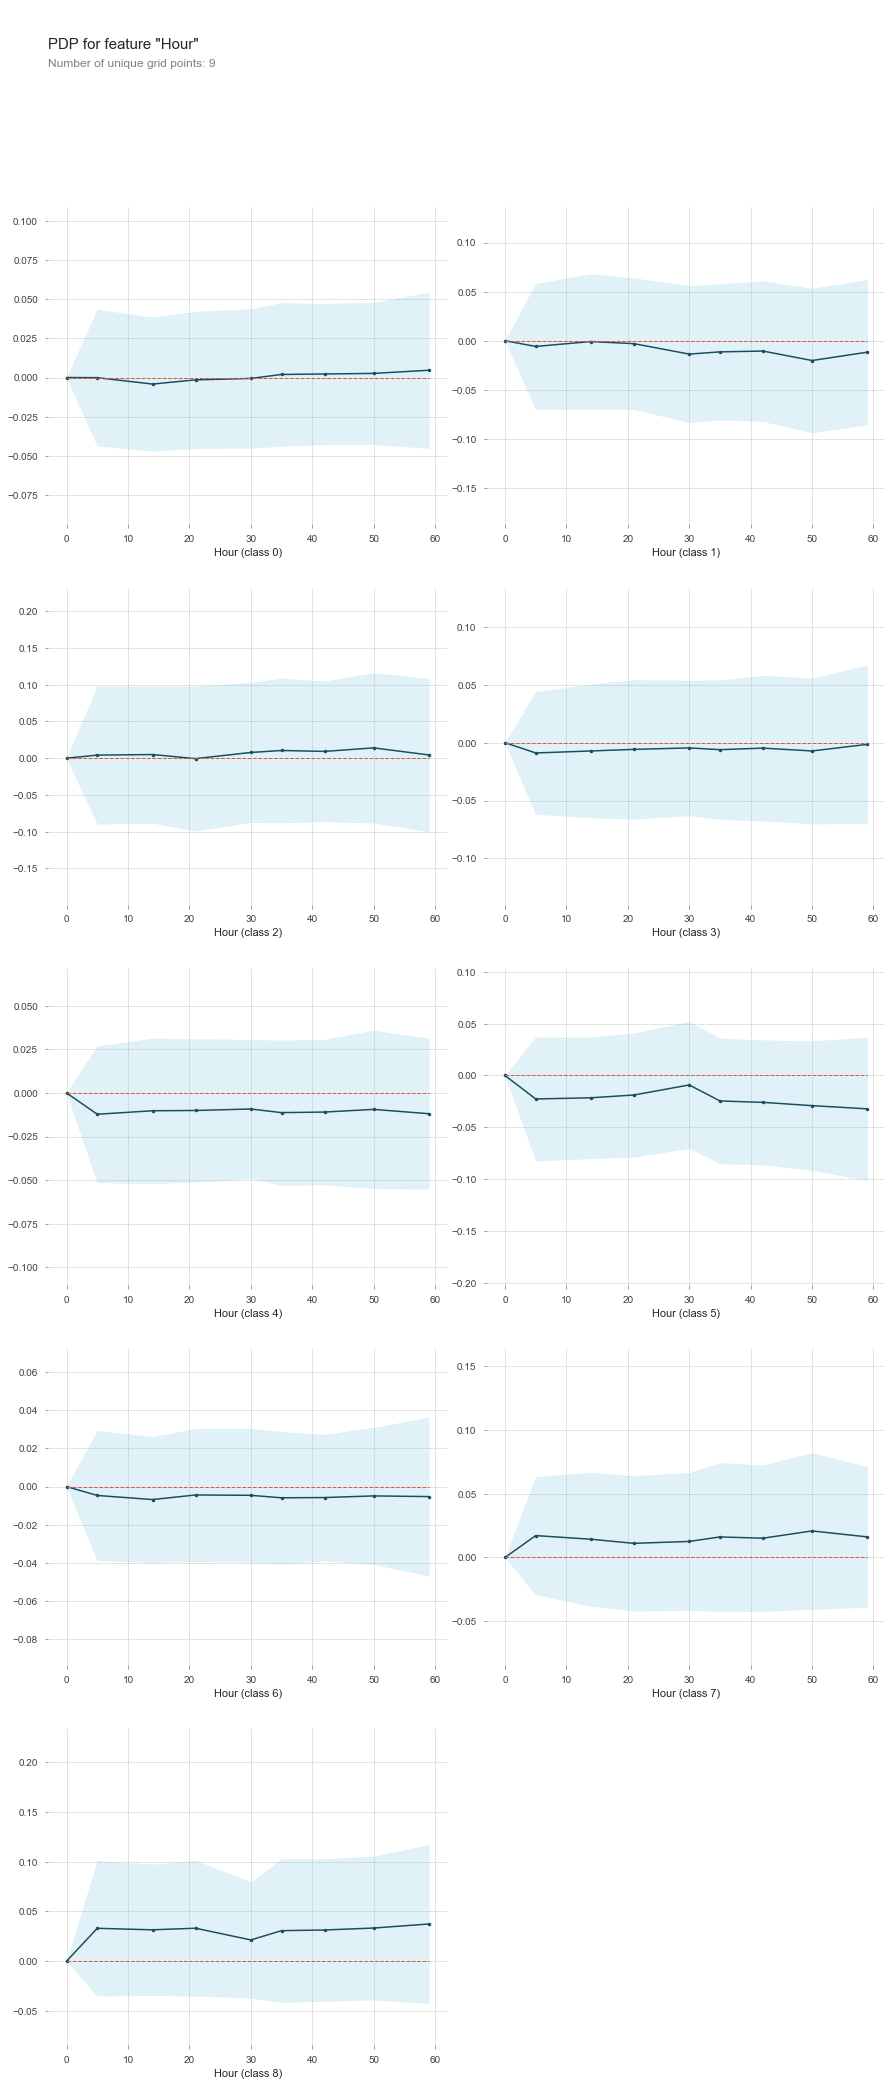

In [70]:
# pdp plot for Minute
%matplotlib inline
feature0 = "Minute"
isolated = pdp.pdp_isolate(model = pipe, 
                                 dataset = X_test, 
                                 model_features = X_test.columns, 
                                 feature = feature0)
pdp_plot(isolated, feature_name=feature);

In [71]:
# PDP with Ice curves for Minute
# PDP: Partial Dependence Plot
# ICE: Individual Conditional Expectation
pdp_plot(isolated, feature_name=feature0, plot_lines=True, 
         frac_to_plot=0.01)

plt.xlim(20000,150000);

In [72]:
# feature interaction partial dependence plot (heatmap) with Hour and Minute
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features =['Hour','Minute']

interaction = pdp_interact(model=pipe, dataset=X_test, 
                           model_features=X_test.columns, features=features)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features)

(<Figure size 1080x2844 with 19 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a3019c790>,
  'pdp_inter_ax': [<matplotlib.axes._subplots.AxesSubplot at 0x1a3307b750>,
   <matplotlib.axes._subplots.AxesSubplot at 0x1a39866d50>]})

In [73]:
# feature interaction partial dependence plot (heatmap) with Hour and Victims
features =['Hour','Victims']

interaction = pdp_interact(model=pipe, dataset=X_test, 
                           model_features=X_test.columns, features=features)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features)

(<Figure size 1080x2844 with 19 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a2201ad90>,
  'pdp_inter_ax': [<matplotlib.axes._subplots.AxesSubplot at 0x1a223b01d0>,
   <matplotlib.axes._subplots.AxesSubplot at 0x1a3bab7ad0>]})

(<Figure size 1080x2844 with 19 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a223e2a90>,
  'pdp_inter_ax': [<matplotlib.axes._subplots.AxesSubplot at 0x1a3c818390>,
   <matplotlib.axes._subplots.AxesSubplot at 0x1a523b22d0>]})

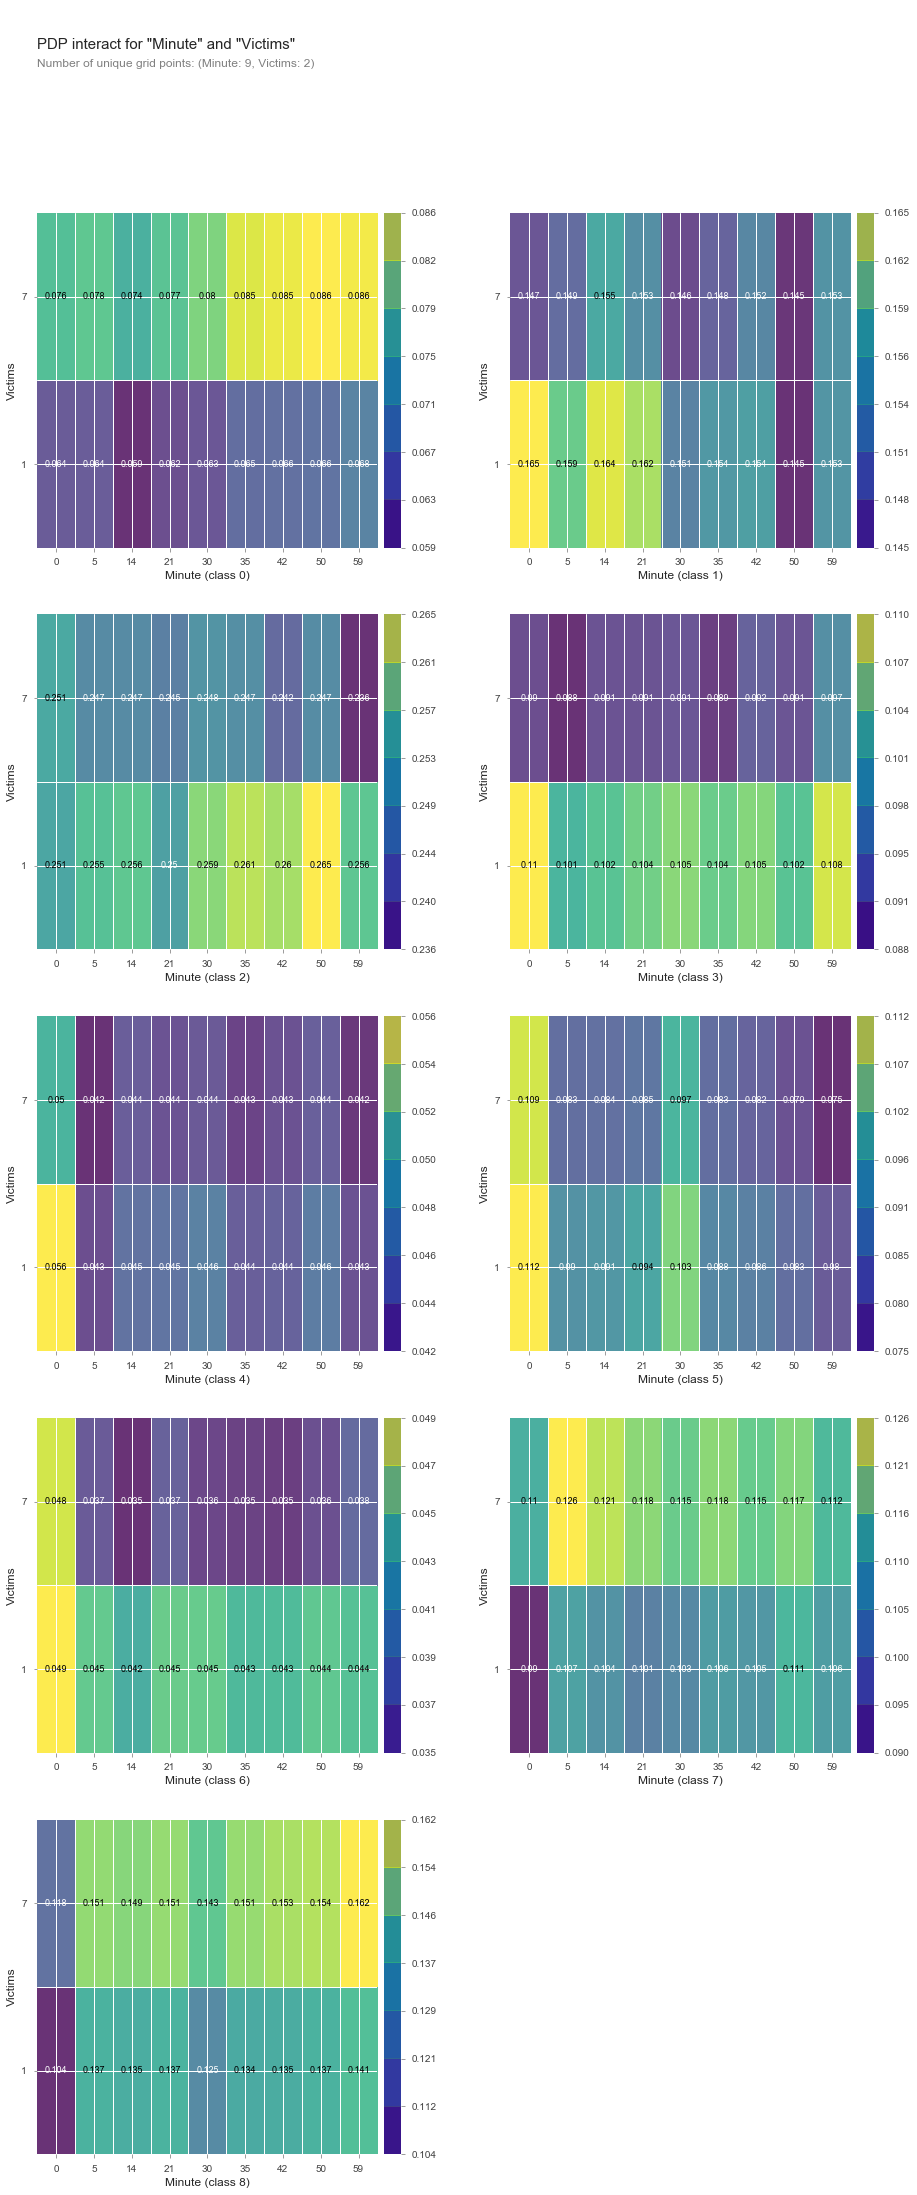

In [74]:
# feature interaction partial dependence plot (heatmap) with Minute and Victims
features =['Minute','Victims']

interaction = pdp_interact(model=pipe, dataset=X_test, 
                           model_features=X_test.columns, features=features)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features)

# Save the Model

In [50]:
# model dumped 
filename = 'finalized_model.joblib'
joblib.dump(pipe, filename)

['finalized_model.joblib']